In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tqdm as tqdm
from sklearn.utils import resample

import keras
from transformers import AutoImageProcessor, TFViTModel, ViTForImageClassification, TFSegformerForSemanticSegmentation
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, jaccard_score
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras import metrics

from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.metrics import jaccard_score

In [ ]:
df_medium_binary = pd.read_csv('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/df-128_binary_label.csv').dropna()

In [ ]:
folder = '/content/drive/MyDrive/Proyecto Cultivos/deepglobe/tiles-128/'

In [ ]:
df_medium_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289730 entries, 0 to 289729
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_name  289730 non-null  object
 1   label       289730 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


Vamos a trabajar con un subset algo más grande que en los casos anteriores (**80.000 muestras**).
El proceso de carga será similar, agregando las máscaras en esta ocasión.

# Carga y pre-procesado

In [ ]:
cut_number = 80000
classes = df_medium_binary['label'].unique()
df_Xsmall_binary = pd.DataFrame(columns=['image_name', 'label'])

for class_name in classes:
    class_samples = df_medium_binary[df_medium_binary['label'] == class_name]
    # Number of samples per class
    num_samples = min(cut_number // len(classes), len(class_samples))
    # Randomly undersampled balanced
    class_samples_balanced = resample(
        class_samples,
        replace = False,
        n_samples = num_samples,
        random_state = 42
    )
    df_Xsmall_binary = df_Xsmall_binary.append(class_samples_balanced, ignore_index=True)

# Randomly shuffled
df_Xsmall_binary = df_Xsmall_binary.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_Xsmall_binary.info()

In [ ]:
def load_process_images_and_masks(folder, df, size=128, batch_size=32):
    width = size
    height = size

    image_files = df['image_name'].tolist()

    # Initialize lists to store image data and masks
    images = []
    masks = []

    # Loop through the image files
    for start_idx in range(0, len(image_files), batch_size):
        end_idx = start_idx + batch_size
        batch_files = image_files[start_idx:end_idx]

        batch_images = []
        batch_masks = []

        for image_file in batch_files:
            # Construct the full file paths for image and mask
            image_path = os.path.join(folder, image_file)
            mask_file = image_file.replace('sat', 'mask').replace('.jpg', '.png')

            # Load the image
            image = cv2.imread(image_path)
            # Check if the image is None
            if image is None:
                print(f"Error loading image: {image_file}")
                continue  # Skip this image

            # Load the corresponding mask
            mask_path = os.path.join(folder, mask_file)
            mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            # Check if mask is None
            if mask is None:
                print(f"Error loading mask: {mask_file}")
                continue
            # Check if mask is empty
            if np.all(mask == 0):
                print(f"Empty mask: {mask_file}")
                continue

            # Resize both the image and mask
            image = cv2.resize(image, (width, height))
            mask = cv2.resize(mask, (width, height))

            # Normalize the image to values between 0 and 1
            image = image.astype(np.float32) / 255.0

            batch_images.append(image)
            batch_masks.append(mask)

        # Append the images and masks to their respective lists
        images.extend(batch_images)
        masks.extend(batch_masks)

    # Convert the lists of images and masks to NumPy arrays
    images = np.array(images)
    masks = np.array(masks)

    return images, masks

images, masks = load_process_images_and_masks(folder, df=df_Xsmall_binary)


In [ ]:
np.savez_compressed('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/datacompressed-128_binary_segmentation.npz', images=images, masks=masks)


In [ ]:
# Load the data
loaded_data = np.load('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/datacompressed-128_binary_segmentation.npz')

# Access images and masks from the loaded data
loaded_images = loaded_data['images']
loaded_masks = loaded_data['masks']

del loaded_data

In [ ]:
label_mapping = {
    'No agriculture': 0,
    'agriculture_land': 1
}

df_Xsmall_binary['label'] = df_Xsmall_binary['label'].map(label_mapping)

In [ ]:
# Definimos el color de 'agriculture_land'
agriculture_color = (255, 255, 0)

binary_masks = []

# Recorremos las máscaras para crear las binarias (ya que las máscaras originales son multiclase)
for original_mask in loaded_masks:
    # Binary mask. 'agriculture_land' pixeless = 1, el resto = 0
    binary_mask = np.zeros_like(original_mask[:, :, 0], dtype=np.uint8)
    binary_mask[np.all(original_mask == agriculture_color, axis=-1)] = 1

    binary_masks.append(binary_mask)

# Lista de binary masks a array
binary_masks = np.array(binary_masks)

np.savez_compressed('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/datacompressed-128_binary_segmentation.npz', images=loaded_images, masks=binary_masks)

In [ ]:
# Descargamos de memoria loaded_images y loaded_masks, que ya no necesitamos

del loaded_images
del loaded_masks

loaded_data = np.load('/content/drive/MyDrive/Proyecto Cultivos/deepglobe/datacompressed-128_binary_segmentation.npz')


binary_images = loaded_data['images']
binary_masks = loaded_data['masks']

# Vamos a filtrar aquellas máscaras que sean todo ceros, que podrían dar algún problema en el entrenamiento

# Máscara para identificar aquellas que sean todo ceros
all_zeros_mask = np.all(binary_images == 0, axis=(1, 2, 3)) & np.all(binary_masks == 0, axis=(1, 2))

# Filtro all_zeros_mask
binary_images = binary_images[~all_zeros_mask]
binary_masks = binary_masks[~all_zeros_mask]

del loaded_data

# Modelado U-Net

In [ ]:
# Para evitar problemas de memoria, utilizaremos la librería Dask, que trocea el conjunto de datos en partes manejables
# para la memoria

import dask.array as da

binary_images_dask = da.from_array(binary_images, chunks=(100, 128, 128, 3))
binary_masks_dask = da.from_array(binary_masks, chunks=(100, 128, 128))

del binary_images
del binary_masks

X_train, X_test, y_train, y_test = train_test_split(binary_images_dask, binary_masks_dask, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)



C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\__init__.py:185: PerformanceWarning: Slicing with an out-of-order index is generating 85 times more chunks
  return array[key] if axis == 0 else array[:, key]
C:\ProgramData\anaconda3\lib\site-packages\sklearn\utils\__init__.py:185: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return array[key] if axis == 0 else array[:, key]


In [ ]:
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (57800, 128, 128, 3)
y_train: (57800, 128, 128)
X_val: (10200, 128, 128, 3)
y_val: (10200, 128, 128)
X_test: (12000, 128, 128, 3)
y_test: (12000, 128, 128)


Vamos a realizar el entrenamiento con una CNN inspirada en U-Net

In [ ]:
input_shape = (128, 128, 3)

# Definimos una arquitectura de tipo U-Net
def create_unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up2 = UpSampling2D(size=(2, 2))(conv3)
    up2 = concatenate([conv2, up2], axis=-1)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(up2)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up1 = UpSampling2D(size=(2, 2))(conv4)
    up1 = concatenate([conv1, up1], axis=-1)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up1)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs, outputs)
    return model

model_unet = create_unet_model(input_shape)

In [ ]:
param_dist = {
    'learning_rate': np.random.uniform(0.0001, 0.1, size=10),
    'batch_size': [16, 32, 64],
    'num_hidden_units': [64, 128, 256],
    'dropout_rate': np.random.uniform(0.2, 0.5, size=10)
}

num_trials = 20
epochs = 10
best_hyperparameters = None
best_validation_accuracy = 0.0

for _ in range(num_trials):
    sampled_params = {
      'learning_rate': np.random.choice(param_dist['learning_rate']),
      'batch_size': np.random.choice(param_dist['batch_size']),
      'num_hidden_units': np.random.choice(param_dist['num_hidden_units']),
      'dropout_rate': np.random.choice(param_dist['dropout_rate'])
    }

    model_unet.compile(optimizer=Adam(learning_rate=sampled_params['learning_rate']),
                     loss='categorical_crossentropy',
                     metrics=[metrics.BinaryCrossentropy()])
    H = model_unet.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=sampled_params['batch_size'])

    # Apply a threshold to convert predicted probabilities to binary masks
    threshold = 0.5
    y_pred_binary_val = (y_pred_model_unet_val > threshold).astype(int)

    # Flatten the predicted masks and ground truth masks
    y_pred_model_unet_val_flat = y_pred_binary_val.reshape(-1)
    y_val_flat = y_val.reshape(-1)

    # Calculate the Jaccard Index (IoU)
    iou_score = jaccard_score(y_val_flat, y_pred_model_unet_val_flat)

    if iou_score > best_mean_iou:
        best_mean_iou = iou_score
        best_hyperparameters = sampled_params


print("Best Hyperparameters:", best_hyperparameters)
print("Best best_mean_iou:", best_mean_iou)

1807/1807 [==============================] - ETA: 0s - loss: 79.3210 - binary_crossentropy: 13.2948WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.


In [ ]:
epochs = 30
batch_size = 256

'''
# Drop learning rate scheduler
def learning_rate_scheduler(epoch, learning_rate):
  if epoch % epochs_drop == 0 and epoch != 0:
    return learning_rate * drop_rate
  else:
    return learning_rate


initial_learning_rate =0.0669615757398038
epochs_drop = 150
drop_rate = 0.95
lr_scheduler = LearningRateScheduler(learning_rate_scheduler)
optimizer = Adam(learning_rate=initial_learning_rate)
# Early Stopping
early_stopping = EarlyStopping(monitor=['val_loss', 'mean_iou'], patience=400, restore_best_weights=True)
'''

optimizer = Adam(learning_rate=5e-4)

model_unet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[metrics.BinaryCrossentropy()])
H = model_unet.fit(X_train, y_train,
                   validation_data=(X_val, y_val),
                   epochs=epochs,
                   batch_size=batch_size)




Epoch 1/30
226/226 [==============================] - 9510s 42s/step - loss: 0.2874 - binary_crossentropy: 0.2874 - val_loss: 0.2419 - val_binary_crossentropy: 0.2419
Epoch 2/30
226/226 [==============================] - 10183s 45s/step - loss: 0.2054 - binary_crossentropy: 0.2054 - val_loss: 0.1834 - val_binary_crossentropy: 0.1834
Epoch 3/30
226/226 [==============================] - 12877s 57s/step - loss: 0.1817 - binary_crossentropy: 0.1817 - val_loss: 0.1846 - val_binary_crossentropy: 0.1846
Epoch 4/30
226/226 [==============================] - 11041s 49s/step - loss: 0.1715 - binary_crossentropy: 0.1715 - val_loss: 0.1703 - val_binary_crossentropy: 0.1703
Epoch 5/30
226/226 [==============================] - 12866s 57s/step - loss: 0.1625 - binary_crossentropy: 0.1625 - val_loss: 0.1511 - val_binary_crossentropy: 0.1511
Epoch 6/30
226/226 [==============================] - 13725s 61s/step - loss: 0.1553 - binary_crossentropy: 0.1553 - val_loss: 0.1530 - val_binary_crossentropy: 

In [ ]:
print("Evaluación del modelo...")
y_pred_modelViT_val = model_unet.predict(X_val, batch_size=128)

#y_pred_modelViT_test = modelViT.predict(X_test, batch_size=128)


# Flatten the predicted masks and ground truth masks
y_pred_modelViT_val_flat = y_pred_modelViT_val.reshape(-1)
y_val_flat = y_val.reshape(-1)

# threshold to convert predicted probabilities to binary masks
threshold = 0.5
y_pred_binary_val = (y_pred_modelViT_val_flat > threshold).astype(int)


# Flatten the predicted masks and ground truth masks
y_pred_modelViT_val_flat = y_pred_binary_val  # Use the binary prediction
y_val_flat = y_val_flat  # Ground truth masks are already flattened

# Jaccard Index (IoU)
iou_score = jaccard_score(y_val_flat, y_pred_modelViT_val_flat)

print(f"IoU Score (Validation): {iou_score}")

Evaluación del modelo...
80/80 [==============================] - 375s 5s/step
IoU Score (Validation): 0.6860715426499436


Vamos a probar con algunas imágenes:

C:/Users/Conaf/Desktop/Generacion_Vectores_deepglobe/test_tiles-128/6520_sat_tile_7_5.jpg
1/1 [==============================] - 0s 56ms/step


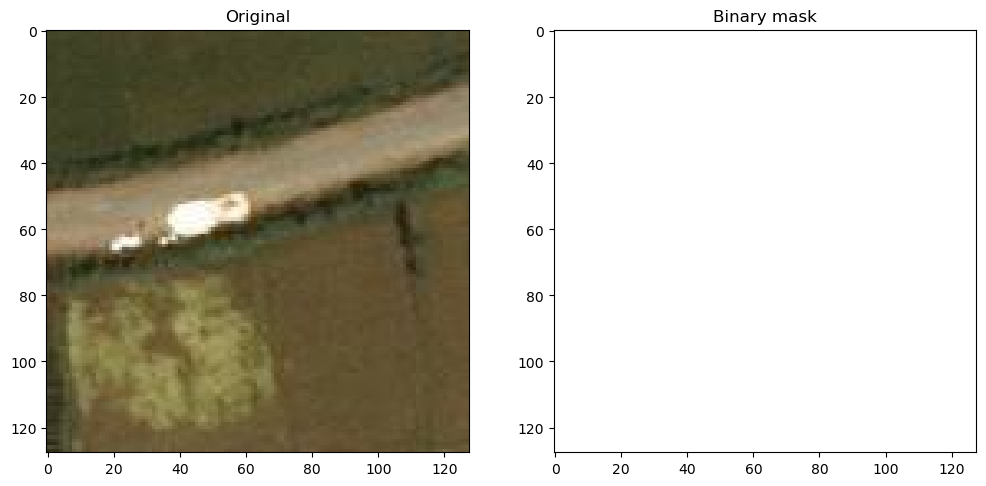

In [ ]:
test_folder = '/content/drive/MyDrive/Proyecto Cultivos/deepglobe/test_tiles-128/'
image_path = os.path.join(test_folder, '6520_sat_tile_7_5.jpg')
print(image_path)
image = cv2.imread(image_path)
image = cv2.resize(image, (128, 128))
image = image.astype(np.float32) /255.

prediction_ = model_unet.predict(np.expand_dims(image, axis=0))

threshold = 0.5
binary_mask = (prediction_ > threshold).astype(np.uint8)[0]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(binary_mask, cmap='binary', vmin=0, vmax=1)
plt.title('Binary mask')

plt.show()

# Modelado Transformers -- NO FUNCIONAL TODAVÍA --

Pruebas con Transformers: -- NO FUNCIONALES TODAVÍA --

In [ ]:

from transformers import ViTFeatureExtractor
from tensorflow.keras import layers

model_id = "google/vit-base-patch16-224-in21k"

feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

data_augmentation = keras.Sequential(
    [
        layers.Resizing(feature_extractor.size, feature_extractor.size),
        layers.Rescaling(1./255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)



In [ ]:
 # AQUÍ ESTAMOS TRABAJANDO CON SEGFORMER


from transformers import AutoImageProcessor, TFSegformerForSemanticSegmentation


image_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
seg_model = TFSegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

num_classes = 1

seg_model.layers[-1] = Conv2D(num_classes, (1, 1), activation='sigmoid')



In [ ]:
seg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])

batch_size = 32
epochs = 1

H_seg = seg_model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs)

In [ ]:
def max_intensity_total(image):
    b, g, r = cv2.split(image)
    total_intensity_b = b.sum()
    total_intensity_g = g.sum()
    total_intensity_r = r.sum()

    dominant_channel_total = 'Blue'
    max_intensity = total_intensity_b

    if total_intensity_g > max_intensity:
        dominant_channel_total = 'Green'
        print(f"Green: {total_intensity_g}")
        max_intensity = total_intensity_g
        coef_rg = total_intensity_r / total_intensity_g
        print(f"coef_rg: {coef_rg}")
    if coef_rg > 1.09:
        dominant_channel_total = 'Red'
        print(f"Red: {total_intensity_r}")

    return dominant_channel_total



def max_intensity_avg(image):
    b, g, r = cv2.split(image)
    avg_intensity_b = b.mean()
    avg_intensity_g = g.mean()
    avg_intensity_r = r.mean()

    dominant_channel_avg = 'Blue'
    max_intensity = avg_intensity_b

    if avg_intensity_g > max_intensity:
        dominant_channel_avg = 'Green'
        print(f"Green: {avg_intensity_g}")
        max_intensity = avg_intensity_g
        coef_rg = avg_intensity_r / avg_intensity_g
        print(f"coef_rg: {coef_rg}")
    if coef_rg > 1.09:
        dominant_channel_avg = 'Red'
        print(f"Red: {avg_intensity_r}")

    return dominant_channel_avg

In [ ]:
image_path = os.path.join(folder, '2334_sat_tile_8_3.jpg')
image = cv2.imread(image_path)


if image is None:
    print(f"No hay imagen {image_path}")
else:
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    print(f"Dominant channel (max): {max_intensity_total(image)}")
    print(f"Dominant channel (avg): {max_intensity_avg(image)}")